# Stage 1 : Classification

In [ ]:
import pandas as pd
import numpy as np
import re
import glob
from sklearn.metrics import confusion_matrix

## Generate and preprocess training and testing data for classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img_dir = r'C:\Users\Work\Downloads\train'
img_dir = img_dir.replace('\\', '/')
img_files = os.listdir(img_dir)

In [ ]:
search_path = os.path.join(img_dir, "**",  "*.png")
files = glob.glob(search_path, recursive=True)
img_files = [f.replace('\\', '/') for f in files]
print(len(img_files))

In [ ]:
filename = []
height = 133
width = 133
image_data = np.zeros((len(img_files), height, width),dtype=np.uint8)

for i,img_path in enumerate(img_files):
#     img = Image.open(img_path)
#     if img.mode != 'L':
#         img = img.convert('L')             
#     img_np = np.asarray(img)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    img = cv2.resize(img, (height, width), interpolation=cv2.INTER_LINEAR)
    img_np = np.asarray(img)
#     print(img_np.dtype)
    label1 = re.search(r'case[\d]+_day[\d]+', img_path)
    label2 = re.search(r'slice_[\d]+', img_path)
    fn = label1[0]+"_"+label2[0]
    image_data[i] = img_np
    filename.append(fn)
    print(i)


In [ ]:
print(image_data.shape)
print(filename)

In [ ]:
# Save data into files
np.save('img_data.npy', image_data)
# print(filename)
with open('filename.txt', 'w') as f:
    # Write each element of the list to a new line in the file
    for element in filename:
        f.write(str(element) + '\n')

In [ ]:
# Import data from files
image_data = np.load('/content/drive/MyDrive/EECS545 Final Project/img_data.npy')
with open('/content/drive/MyDrive/EECS545 Final Project/filename.txt', 'r') as file:
    filename = [line.strip() for line in file.readlines()]
# print(filename)

In [ ]:
# Create Label for organs existence (0,1)
df = pd.read_csv('/content/drive/MyDrive/EECS545 Final Project/train.csv')
df.loc[df['segmentation'].notna(), 'segmentation'] = 1
df.loc[df['segmentation'].isna(), 'segmentation'] = 0
# df.head()

In [ ]:
# Step 1: Data preparation to identify the existence of Stomach
import random
random.seed(545)

filtered_df = df[df['class'] == 'small_bowel']
# filtered_df = df[df['class'] == 'large_bowel']
# filtered_df = df[df['class'] == 'stomach']
stom_df = filtered_df[filtered_df['id'].isin(filename)]

x = []
for i,img in enumerate(image_data):
    x.append(img.reshape(-1))
# print(x)
y = stom_df['segmentation'].tolist()

y1_idx = [i for i, x in enumerate(y) if x==1]
random.shuffle(y1_idx)
y0_idx = [i for i, x in enumerate(y) if x==0]
random.shuffle(y0_idx)

# upsample the list to length n
n = len(y0_idx)
prop = 0.73

train_idx = [*np.random.choice(y1_idx[:int(len(y1_idx)*prop)], n),*y0_idx[:int(len(y0_idx)*prop)]]
test_idx = [*y1_idx[int(len(y1_idx)*prop):],*y0_idx[int(len(y0_idx)*prop):]]

## SVM training

In [ ]:
# SVM
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

x_train =  [x[i] for i in train_idx]
y_train =  [y[i] for i in train_idx]
y_test = [y[i] for i in test_idx]
x_test = [x[i] for i in test_idx]

In [ ]:
!pip install scikit-learn-intelex

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

In [ ]:
import joblib
joblib.parallel_backend('multiprocessing', n_jobs=-1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f1)
print(conf_matrix)
print((conf_matrix[0,0]+conf_matrix[1,1]) / conf_matrix.sum())
recall = conf_matrix[1,1] / conf_matrix[1,:].sum()
print(recall)

In [ ]:
# Prepare data for CNN
train_images =  image_data[train_idx]
train_labels =  np.array([y[i] for i in train_idx])

test_images = image_data[test_idx]
test_labels =  np.array([y[i] for i in test_idx])
print(train_images.shape)
print(np.unique(test_labels))

(47220, 133, 133)
[0 1]


### CNN training

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.metrics import Recall
from keras.regularizers import l1_l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import backend as K

def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    
    bce = K.binary_crossentropy(y_true, y_pred)
    p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
    modulating_factor = K.pow((1 - p_t), gamma)
    return K.mean(alpha_factor * modulating_factor * bce)


model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(133, 133, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25)

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss=focal_loss, metrics=['Recall'])
model.summary()

callbacks_list = [
    callbacks.EarlyStopping(monitor='loss', patience=5),
    callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
    callbacks.TensorBoard(log_dir='logs', histogram_freq=1, embeddings_freq=1, write_graph=True)
]

model.fit(train_images, train_labels, epochs=30, verbose=True,
          validation_data=(test_images, test_labels), callbacks=callbacks_list)

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/EECS545 Final Project/my_model.h5')
y_pred = loaded_model.predict(test_images)

325/325 [==============================] - 14s 15ms/step


In [ ]:
y_pred_res = [1 if x > 0.5 else 0 for x in y_pred]

cm = confusion_matrix(test_labels, y_pred_res)
print(cm)
print((cm[0,0]+cm[1,1]) / cm.sum())

from sklearn.metrics import f1_score
f1 = f1_score(test_labels, np.round(y_pred))
print(f1)

recall = cm[1,1] / cm[1,:].sum()
print(recall)

[[7250  120]
 [ 237 2788]]
0.9656565656565657
0.9398280802292264
0.9216528925619835


In [ ]:
y_pred_res = [1 if x > 0.0009 else 0 for x in y_pred]
cm = confusion_matrix(test_labels, y_pred_res)
print(cm)
print((cm[0,0]+cm[1,1]) / cm.sum())

from sklearn.metrics import f1_score
f1 = f1_score(test_labels, np.round(y_pred))
print(f1)

recall = cm[1,1] / cm[1,:].sum()
print(recall)

[[4687 2683]
 [   7 3018]]
0.7412217412217412
0.9398280802292264
0.9976859504132232


# Stage 2: Segmentation

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from torchvision.transforms import ToTensor
class CustomDataset(Dataset):
    def __init__(self, image_file, label_file, transform=None):
        self.images = np.load(image_file)
        # self.images = (self.images - np.mean(self.images)) / np.std(self.images)
        self.labels = np.load(label_file)
        self.transform = transform
        # self.max_value = np.amax(self.images)
        # self.min_value = np.amin(self.images)

    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
          seed = np.random.randint(2147483647)
          random.seed(seed)
          image = Image.fromarray(image)
          image = self.transform(image)

          random.seed(seed)
          label = Image.fromarray(label)
          label = self.transform(label)

          image = np.array(label)
          label = np.array(label)        

        # # Convert image and label to torch tensors
        # image = (image - self.min_value) / (self.max_value - self.min_value)
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()

        return image, label

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedFocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, gamma=2, beta=0.3, eps=1e-7, focal_weight=0.5):
        super(CombinedFocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.eps = eps
        self.focal_weight = focal_weight
        self.tversky_weight = 1 - focal_weight

    def focal_loss(self, y_pred, y_true):
        bce = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
        p_t = torch.exp(-bce)
        focal_loss = self.alpha * (1 - p_t)**self.gamma * bce
        return focal_loss.mean()

    def tversky_loss(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        tp = (y_pred * y_true).sum()
        fp = ((1 - y_true) * y_pred).sum()
        fn = (y_true * (1 - y_pred)).sum()
        tversky_index = (tp + self.eps) / (tp + self.beta * fn + (1 - self.beta) * fp + self.eps)
        tversky_loss = 1 - tversky_index
        return tversky_loss

    def forward(self, y_pred, y_true):
        focal = self.focal_loss(y_pred, y_true)
        tversky = self.tversky_loss(y_pred, y_true)
        combined_loss = self.focal_weight * focal + self.tversky_weight * tversky
        return combined_loss

In [ ]:
criterion = CombinedFocalTverskyLoss(alpha=0.75, gamma=4, beta=0.2, focal_weight=0.33)

### ResNet50 + ViT

In [ ]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import timm
import torch.nn.functional as F

torch.cuda.empty_cache()
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        # ResNet50
        self.resnet50 = models.resnet50(pretrained=True)
        
        # ResNet50 encoder layers
        self.encoder1 = nn.Sequential(*list(self.resnet50.children())[:5])
        self.encoder2 = list(self.resnet50.children())[5]
        self.encoder3 = list(self.resnet50.children())[6]
        self.encoder4 = list(self.resnet50.children())[7]

        # Vision Transformer
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0, drop_rate=0.1)

        # Decoder layers
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(2816, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(512, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        
        self.batch_norm = nn.BatchNorm2d(num_classes)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        vit_features = self.vit(x_resized)

        vit_features = vit_features.unsqueeze(-1).unsqueeze(-1) 
        vit_features = F.interpolate(vit_features, size=e4.shape[2:], mode='nearest') 

        combined_features = torch.cat([e4, vit_features], dim=1)

        d4 = self.decoder4(combined_features)
        d4_adapt = F.adaptive_avg_pool2d(d4, e3.size()[2:])
        d3 = self.decoder3(torch.cat([d4_adapt, e3], dim=1))
        d3_adapt = F.adaptive_avg_pool2d(d3, e2.size()[2:])
        d2 = self.decoder2(torch.cat([d3_adapt, e2], dim=1))
        d2_adapt = F.adaptive_avg_pool2d(d2, e1.size()[2:])
        d1 = self.decoder1(torch.cat([d2_adapt, e1], dim=1))

        output = F.interpolate(d1, size=x.shape[2:], mode='bilinear', align_corners=False)
        out = self.batch_norm(output)
        return out

num_classes = 3
model = CombinedModel(num_classes).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


In [ ]:
# Load the saved model state
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Focal_loss_ViT_ResNet50_FCN_seg_model.pt'))
model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/resnet50_vit/Combined_loss_ResNet50_vit_model.pt'))

<All keys matched successfully>

In [ ]:
from torchsummary import summary
print(summary(model, (3, 300, 310)))

In [ ]:
input_tensor = torch.randn(1, 3, 310, 360).to(device)
output = model(input_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 3, 310, 360])


## ResNet50 Only

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
torch.cuda.empty_cache()

class FCN_ResNet(nn.Module):
    def __init__(self, num_classes):
        super(FCN_ResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.layer1 = nn.Sequential(*list(self.resnet.children())[:5])
        self.layer2 = list(self.resnet.children())[5]
        self.layer3 = list(self.resnet.children())[6]
        self.layer4 = list(self.resnet.children())[7]

        self.score_layer1 = nn.Conv2d(256, num_classes, 1)
        self.score_layer2 = nn.Conv2d(512, num_classes, 1)
        self.score_layer3 = nn.Conv2d(1024, num_classes, 1)
        self.score_layer4 = nn.Conv2d(2048, num_classes, 1)
        self.batch_norm = nn.BatchNorm2d(num_classes)

    def forward(self, x):
        input_size = x.size()[2:]

        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        score_layer1 = self.score_layer1(layer1)
        score_layer2 = self.score_layer2(layer2)
        score_layer3 = self.score_layer3(layer3)
        score_layer4 = self.score_layer4(layer4)

        upscore2 = F.interpolate(score_layer4, scale_factor=2, mode='bilinear', align_corners=True)

        h2_size = upscore2.size()[2:]
        score_layer3_adapt = F.adaptive_avg_pool2d(score_layer3, h2_size)
        upscore4 = F.interpolate(upscore2 + score_layer3_adapt, scale_factor=2, mode='bilinear', align_corners=True)

        h4_size = upscore4.size()[2:]
        score_layer2_adapt = F.adaptive_avg_pool2d(score_layer2, h4_size)
        upscore8 = F.interpolate(upscore4 + score_layer2_adapt, scale_factor=2, mode='bilinear', align_corners=True)

        h8_size = upscore8.size()[2:]
        score_layer1_adapt = F.adaptive_avg_pool2d(score_layer1, h8_size)
        upscore16 = F.interpolate(upscore8 + score_layer1_adapt, scale_factor=2, mode='bilinear', align_corners=True)

        upscore32 = F.interpolate(upscore16, size=input_size, mode='bilinear', align_corners=True)

        out = self.batch_norm(upscore32)
        return out

num_classes = 3
model = FCN_ResNet(num_classes).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


In [ ]:
# Load the saved model state
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Focal_loss_ResN_FCN_seg_model.pt'))
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Dice_loss_ResN_FCN_seg_model.pt'))
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Combined_loss_ResN_FCN_seg_model.pt'))
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/New_Combined_loss_ResN_FCN_seg_model.pt'))
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Favor_Dice_Combined_loss_ResN_FCN_seg_model.pt'))
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Favor_Focal_Combined_loss_ResN_FCN_seg_model.pt'))
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/CorrectData/TrainedModelWeights/Combined_loss_ResN_FCN_seg_model.pt'))
model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/CorrectData/TrainedModelWeights/Combined_loss_ResN_FCN_seg_model.pt',
                                 map_location=torch.device('cpu')))
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/CorrectData/TrainedModelWeights/Low_Alpha_Combined_loss_ResN_FCN_seg_model.pt'))

<All keys matched successfully>

In [ ]:
print(summary(model, (3, 310, 360)))

## Train

In [ ]:
image_paths = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/train_input.npy'
label_paths = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/train_labels.npy'
# Create the custom dataset
train_dataset = CustomDataset(image_paths, label_paths, transform=None)

In [ ]:
# for param in model.encoder.parameters():
#   param.requires_grad = False
# for param in model.vit.parameters():
#   param.requires_grad = False

In [ ]:
# for param in model.resnet.parameters():
#   param.requires_grad = False

### Start Training

In [ ]:
# bs = 118 # standard freeze pretrain
# bs = 42 # standard train all
# bs = 280
# 288 # Premium freeze pretrain
bs = 94 # Premium train all
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
optimizer = optim.Adam(model.parameters(), lr=0.00000007, betas=(0.79, 0.89))
# 
print(bs)
print("{:.7f}".format(optimizer.param_groups[0]['lr']))

94
0.0000001


In [ ]:
num_epochs = 7
num_epochs = 3
train_loss = 0
for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    labels = labels.float()
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  train_loss /= len(train_loader)
  print(f'Epoch: {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}')

print("Training finished.")

Epoch: 1/3, Train Loss: 0.1125
Epoch: 2/3, Train Loss: 0.1126
Epoch: 3/3, Train Loss: 0.1125
Training finished.


In [ ]:
print(train_loss)

0.1125178442246491


### ViT & ResNet50 weights

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/Combined_loss_ViT_ResNet50_FCN_seg_model.pt')

### ResNet50 weights

#### New Data Training Res

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/CorrectData/TrainedModelWeights/Combined_loss_ResN_FCN_seg_model.pt')

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/CorrectData/TrainedModelWeights/Low_Alpha_Combined_loss_ResN_FCN_seg_model.pt')

#### Old Data Training Res

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/Focal_loss_ResN_FCN_seg_model.pt')

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/Dice_loss_ResN_FCN_seg_model.pt')

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/Combined_loss_ResN_FCN_seg_model.pt')

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/New_Combined_loss_ResN_FCN_seg_model.pt')

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/Favor_Dice_Combined_loss_ResN_FCN_seg_model.pt')

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/Favor_Focal_Combined_loss_ResN_FCN_seg_model.pt')

## Test

# New Section

In [ ]:
# Load test dataset
test_data_path = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/test_input.npy'
test_labels_path = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/test_labels.npy'
val_input_path = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/val_input.npy'
val_labels_path = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/val_labels.npy'

# Create a CustomDataset for test data
test_dataset = CustomDataset(test_data_path, test_labels_path, transform=None)
# val_dataset = CustomDataset(val_input_path,val_labels_path, transform=None)

In [ ]:
# Overall Test error
batch_size = 126
# batch_size = 288
# Create a DataLoader for test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
num_classes = 3
# print(len(test_loader))
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# concat_dataset = torch.utils.data.ConcatDataset([test_loader, val_loader])
# final_loader = torch.utils.data.DataLoader(concat_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix

model.eval()

running_auc_roc = 0
running_accuracy = 0
running_f1_score = 0
running_sensitivity = 0
running_specificity = 0

# Test loop
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        binary_preds = (outputs > 0.5).float()

        targets = targets.view(-1, num_classes).cpu().numpy()
        binary_preds = binary_preds.view(-1, num_classes).cpu().numpy()

        for i in range(num_classes):
            running_auc_roc += roc_auc_score(targets[:, i], binary_preds[:, i])
            tn, fp, fn, tp = confusion_matrix(targets[:, i], binary_preds[:, i]).ravel()
            running_accuracy += (tp + tn) / (tp + tn + fp + fn)
            running_f1_score += 2 * tp / (2 * tp + fp + fn)
            running_sensitivity += tp / (tp + fn)
            running_specificity += tn / (tn + fp)

        progress = (batch_idx + 1) / len(test_loader) * 100
        print(f"Progress: {progress:.2f}%")

average_auc_roc = running_auc_roc / (len(test_loader) * num_classes)
average_accuracy = running_accuracy / (len(test_loader) * num_classes)
average_f1_score = running_f1_score / (len(test_loader) * num_classes)
average_sensitivity = running_sensitivity / (len(test_loader) * num_classes)
average_specificity = running_specificity / (len(test_loader) * num_classes)

print(f"Overall Metrics:")
print(f"  Average AUC-ROC: {average_auc_roc}")
print(f"  Average Accuracy: {average_accuracy}")
print(f"  Average F1-score: {average_f1_score}")
print(f"  Average Sensitivity (Recall): {average_sensitivity}")
print(f"  Average Specificity: {average_specificity}")

Progress: 7.14%
Progress: 14.29%
Progress: 21.43%
Progress: 28.57%
Progress: 35.71%
Progress: 42.86%
Progress: 50.00%
Progress: 57.14%
Progress: 64.29%
Progress: 71.43%
Progress: 78.57%
Progress: 85.71%
Progress: 92.86%
Progress: 100.00%
Overall Metrics:
  Average AUC-ROC: 0.7416121161122897
  Average Accuracy: 0.9943759007983921
  Average F1-score: 0.6207588334599283
  Average Sensitivity (Recall): 0.48393962490253467
  Average Specificity: 0.9992846073220447


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLossLogits(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLossLogits, self).__init__()
        self.smooth = smooth

    def forward(self, logits, target):
        pred = torch.sigmoid(logits)
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        cardinalities_sum = pred.sum() + target.sum()

        loss = 1 - (2 * intersection + self.smooth) / (cardinalities_sum + self.smooth)
        return loss

In [ ]:
criterion = DiceLossLogits()
criterion = nn.BCEWithLogitsLoss()

In [ ]:
# Switch the model to evaluation mode
model.eval()

test_error = 0
total_samples = 0

# Iterate through the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()  # Convert the target tensor to float
        
        # Forward pass
        outputs = model(inputs)
        # ['out']
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Update test error and total samples
        test_error += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

# Calculate the average test error
avg_test_error = test_error / total_samples
print("Average Test Error: {:.4f}".format(avg_test_error))


Average Test Error: 0.0366


In [ ]:
input_image = np.load("/content/drive/MyDrive/EECS545 Final Project/new_data/sample_input1.npy")
true_label_image = np.load("/content/drive/MyDrive/EECS545 Final Project/new_data/sample_label1.npy")
input_image = torch.from_numpy(input_image).to(device)
input_image = input_image.view(1,3,310,360).to(torch.float32)

outputs = model(input_image)
probs = torch.sigmoid(outputs)
predicted_labels = (probs > 0.5).float()

input_image = input_image.cpu().squeeze().numpy()
plt.imshow(input_image[1,:,:])
plt.title("Input Image")
plt.show()

# Move the true_label and pred_mask back to the CPU and remove the batch dimension
true_label = true_label_image.squeeze()
pred_mask = predicted_labels.squeeze().cpu().numpy()

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i in range(3):
    ax[0, i].imshow(true_label[i,:,:], cmap='gray')
    ax[0, i].set_title(f"True Label (Channel {i})")
    
    ax[1, i].imshow(pred_mask[i,:,:], cmap='gray')
    ax[1, i].set_title(f"Predicted Mask (Channel {i})")

#plt.savefig("/content/drive/MyDrive/EECS545 Final Project/resnet50/Figure_0epoch.png")
plt.tight_layout()
plt.show()


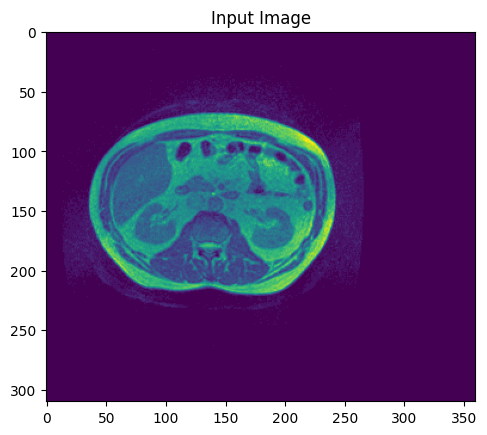

[0. 1.]
[0 1]


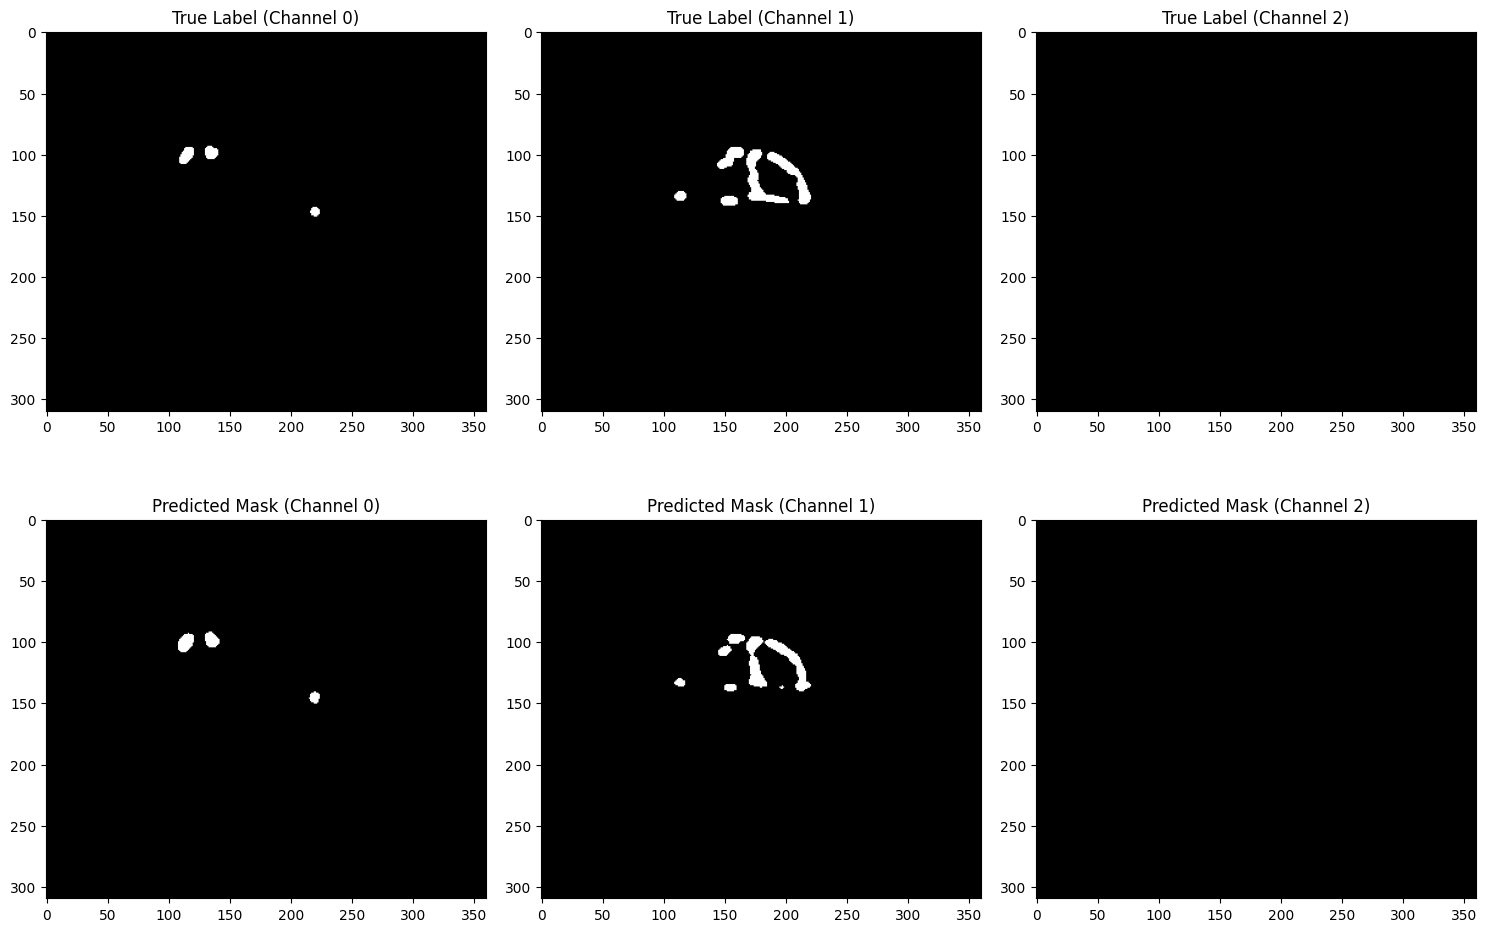

In [ ]:
# Visualize a single test sample
sample_data = np.load('/content/drive/MyDrive/EECS545 Final Project/sample_input1.npy')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
# test_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# test_loader = DataLoader(concat_dataset, batch_size=1, shuffle=True)
model.eval()

test_sample = next(iter(test_loader))
# test_sample = next(iter(test_loader))
inputs, true_labels = test_sample

inputs, true_labels = inputs.to(device), true_labels.to(device)

with torch.no_grad():
    outputs = model(inputs)

probs = torch.sigmoid(outputs)
predicted_labels = (probs > 0.5).float()


import matplotlib.pyplot as plt

input_image = inputs.cpu().squeeze().numpy()
plt.imshow(input_image[1,:,:])
plt.title("Input Image")
plt.show()

true_label = true_labels.squeeze().cpu().numpy()
pred_mask = predicted_labels.squeeze().cpu().numpy()

print(np.unique(pred_mask))
print(np.unique(true_label))
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i in range(3):
    ax[0, i].imshow(true_label[i,:,:], cmap='gray')
    ax[0, i].set_title(f"True Label (Channel {i})")
    
    ax[1, i].imshow(pred_mask[i,:,:], cmap='gray')
    ax[1, i].set_title(f"Predicted Mask (Channel {i})")

plt.tight_layout()
plt.show()

